In [ ]:
!git add .
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"
!git commit -m "blue"
!git push

[main b4825ce] blue
 1 file changed, 403 insertions(+), 29 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 64 threads
Compressing objects: 100% (3/3), done.


In [1]:
!pip install pandas
!pip install pillow
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 48.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 9.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 1.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 56.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 7.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 48.0 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.9 MB/s eta 0:00:00:00:01


In [2]:
import os
#os.environ["KERAS_BACKEND"] = "torch"
import numpy as np
import pandas as pd
from PIL import Image
import random
#import torch
import keras
import h5py
import matplotlib.pyplot as plt
import bz2
import zipfile
import requests
import gc
import timeit
import tensorflow as tf
print(tf.__version__)
print(keras.__version__)

2024-04-22 17:06:50.160437: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1
3.0.5


In [3]:
#print(keras.backend.backend())
#print(torch.__version__)

In [4]:
# Import the labels
input_directory = "kaggle/input/histopathologic-cancer-detection/"
working_directory = "kaggle/working/"
tmp_directory = "kaggle/temp"


In [5]:
def download_file(url, folder_path, local_filename):
    # Make a request to the URL
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for bad responses

    # Create the full path to the file
    file_path = os.path.join(folder_path, local_filename)

    # Write the file content in binary mode to the specified folder
    with open(file_path, 'wb') as file:
        file.write(response.content)



In [11]:
#Download Kaggle File
url = 'https://storage.googleapis.com/isaac_blach_ml_storage/histopathologic-cancer-detection.zip'
folder_path = input_directory
local_filename = 'histopathologic-cancer-detection.zip'

download_file(url, folder_path, local_filename)

In [15]:
with zipfile.ZipFile(input_directory + "histopathologic-cancer-detection.zip", 'r') as zip_ref:
    zip_ref.extractall(input_directory)

In [16]:
directory = input_directory + "train_labels.csv"
images = pd.read_csv(directory)
images.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Cancerous


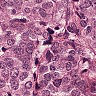

Cancer Free


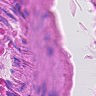

Cancer Free


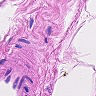

Cancer Free


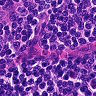

Cancerous


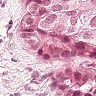

Cancer Free


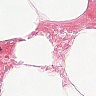

Cancer Free


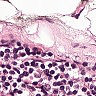

Cancer Free


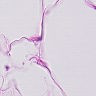

Cancer Free


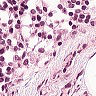

Cancerous


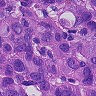

In [19]:
#print random images with lablels
samples = images.iloc[random.sample(range(0,images.shape[0]), 10)]
#print(samples)
for sample in samples.iterrows():
    #print(sample[1])
    path = input_directory + "train/" + str(sample[1]["id"]) + ".tif"
    if sample[1]["label"] == 0:
        print("Cancer Free")
    else:
        print("Cancerous")
    im = Image.open(path)
    display(im)


## EDA
- Cancerous vs Cancer Free numbers in train set
- Size of set
- Find more later

In [16]:
#GPT assisted class

def load_and_process_image(filename):
    path=input_directory + "train/" + filename + ".tif"
    im = keras.utils.load_img(path, color_mode='rgb', target_size=(32,32))
    return keras.utils.img_to_array(im)/255
#Build Rotations


images['image_data'] = images['id'].apply(load_and_process_image)



In [17]:
# Store the results in a file for faster loading
X = np.stack(images['image_data'].values)
y = images['label'].values
path = working_directory + 'image_data.h5'
hdf5_file = path

with h5py.File(hdf5_file, 'w') as f:
    f.create_dataset('images', data=X)
    f.create_dataset('labels', data=y)

In [18]:
#BZ2 Compress for cloud storage
with open(working_directory + "image_data.h5", 'rb') as input_file:
    with bz2.open(working_directory + "image_data.bz2", 'wb', compresslevel=9) as output_file:
        output_file.writelines(input_file)

## Expanding the training set

A good pratice in trianing image data is to rotate and shift the training set to create a better and more complete training set.  In researching this problem, just rotating all the images can create a 5% increase in accuracy if properly tuned.

In [6]:
# Download images non-rotated
url = 'https://storage.googleapis.com/isaac_blach_ml_storage/image_data.bz2'
folder_path = working_directory
local_filename = 'image_data.bz2'

download_file(url, folder_path, local_filename)

#unbz2 images for git storage
with bz2.open(working_directory + "image_data.bz2", 'rb') as compressed_file:
    with open(working_directory + "image_data.h5", 'wb') as decompressed_file:
        # Copy the decompressed data to a new file
        decompressed_file.write(compressed_file.read())

In [7]:
# Load dataset from file
path = working_directory + 'image_data.h5'
hdf5_file = path
with h5py.File(hdf5_file, 'r') as f:
    # Load the datasets back into memory
    X = f['images'][:]
    y = f['labels'][:]

In [8]:
# Rotate Images

def rotate_images(images, k):
    return np.rot90(images, k=k, axes = (1,2))

X_rotated = np.concatenate((X, rotate_images(X, 1), rotate_images(X, 2), rotate_images(X, 3)))
y_rotated = np.concatenate((y,y,y,y))

print("X Shape: " + str(X.shape))
print("X Rotated Shape: " + str(X_rotated.shape))
print("y Shape: " + str(y.shape))
print("y Shape: " + str(y_rotated.shape))

X Shape: (220025, 32, 32, 3)
X Rotated Shape: (880100, 32, 32, 3)
y Shape: (220025,)
y Shape: (880100,)


In [9]:
# Developed with help from https://keras.io/api/models/model/

def convolution_block(inputs, filters, activation = "relu"):
    filters = filters
    kernel_size=(3,3)
    conv1 = keras.layers.Conv2D(
        filters,
        kernel_size,
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation=activation,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    ) (inputs)
    return conv1

def pool_block(inputs):
    pool = keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=None, padding="valid", data_format=None, name=None
    )(inputs)
    return pool

def dropout_block(inputs, dropout_value):
    dropout = keras.layers.Dropout(dropout_value)(inputs)
    return dropout

def activation_block(inputs, layer_density): 
    dense = keras.layers.Dense(layer_density, activation='relu') (inputs)
    return dense

def prep_one_block():
    dropout_value = .25
    inputs = keras.Input(shape=(32,32,3))
    convolution = inputs
    for i in range(0,1):
        convolution = convolution_block(convolution, 32)
        convolution = convolution_block(convolution, 32)
        convolution = pool_block(convolution)
        
    flatten= keras.layers.Flatten()(convolution)

    activation = flatten
    for i in range(0,1):
        activation = activation_block(activation,1024)
        activation = dropout_block(activation, dropout_value)
    outputs = keras.layers.Dense(1, activation="sigmoid")(activation)
    full_model = keras.Model(inputs, outputs)
    return full_model



In [10]:
#added callbacks to cut off a model that has peaked
callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
#The method to compile and fit the model
def run_model(full_model, learning_rate, X, y, epochs = 10, callbacks = None):
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    full_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy()])
    history = full_model.fit(
        x=X,
        y=y,
        batch_size=128,
        epochs=epochs,
        verbose=0,
        callbacks=callbacks,
        validation_split=0.2,
        validation_data=None,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    )
    return full_model, history
    


In [11]:
# Stolen Shamelessly from https://github.com/keras-team/keras/issues/12625 
# Clears up GPU out of memory
#from tensorflow.keras import backend as K

# Reset Keras Session
def reset_keras():
#    K.clear_session()
    gc.collect()
#    tf.keras.backend.clear_session()
          

# Chatgpt wrote this imaging plot
def plot_error(train_accuracy, val_accuracy, text):
    epochs = range(1, len(train_accuracy) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o', linestyle='-', color='blue')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', linestyle='-', color='red')

    # Loop through each epoch and add text annotation for training and validation accuracy
    for i, (train_acc, val_acc) in enumerate(zip(train_accuracy, val_accuracy)):
        plt.text(i + 1, train_acc, f'{train_acc:.2f}', ha='center', va='bottom')
        plt.text(i + 1, val_acc, f'{val_acc:.2f}', ha='center', va='top')
    
    title_string = text
    plt.title(title_string)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')  # Changed 'Loss' to 'Accuracy' as we are plotting accuracy values
    plt.legend()
    plt.grid(True)
    plt.show()

2024-04-20 19:33:16.545488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22283 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:a1:00.0, compute capability: 8.9
I0000 00:00:1713641602.032119   83508 service.cc:145] XLA service 0x7fcf40004ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713641602.032197   83508 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-20 19:33:22.150171: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-20 19:33:22.337770: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1713641604.265491   83508 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the life

43.11685061798198


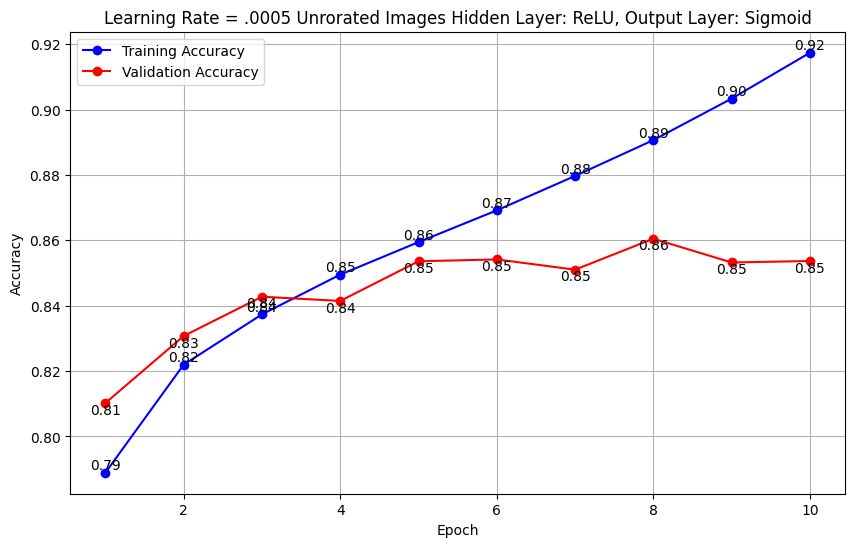

In [10]:
model = prep_one_block()
start_time = timeit.default_timer()
_, history = run_model(model, .0005, X, y)
print(timeit.default_timer() - start_time)
text = "Learning Rate = .0005 Unrorated Images Hidden Layer: ReLU, Output Layer: Sigmoid"
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(model)
reset_keras()

185.62978986400412


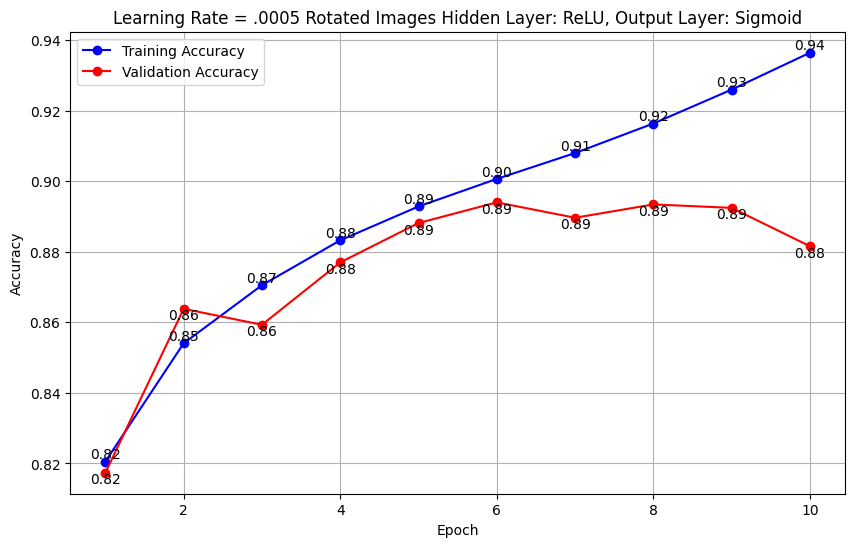

In [15]:
model = prep_one_block()
start_time = timeit.default_timer()
_, history = run_model(model, .0005, X_rotated, y_rotated)
print(timeit.default_timer() - start_time)
text = "Learning Rate = .0005 Rotated Images Hidden Layer: ReLU, Output Layer: Sigmoid"
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(model)
reset_keras()

## Initial Impressions
.85 Validation with the unrotated images is ok.  With rotated Images, I'm getting .89. but after the 5-8th epoch, there is major overfitting.

## Testing different hidden layers and output layers
I'm going to try this with different hidden layer options.  I'm testing all the hidden layers avaliable.  I also dropped the number of epochs to make more sense.

## Cutting the model off after validation accuracy starts to fall
I set up a callback to cut the model off after 2 epochs of falling validation accuracy

2024-03-29 16:28:36.855878: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8651735040 exceeds 10% of free system memory.
2024-03-29 16:28:43.223042: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8651735040 exceeds 10% of free system memory.
I0000 00:00:1711729729.690026     833 service.cc:145] XLA service 0x7f51600049f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1711729729.690101     833 service.cc:153]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
I0000 00:00:1711729729.690110     833 service.cc:153]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2024-03-29 16:28:49.795870: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-29 16:28:50.261243: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDN

114.50265001133084


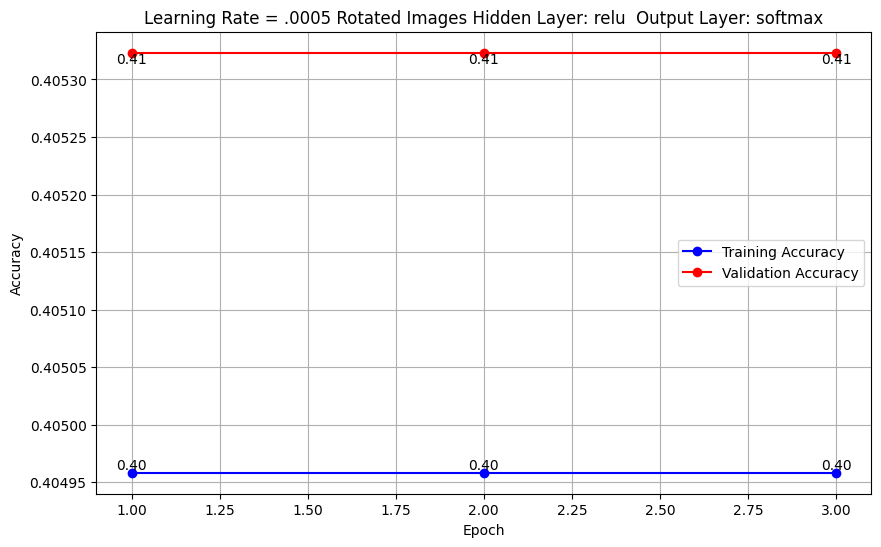

2024-03-29 16:30:27.906213: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8651735040 exceeds 10% of free system memory.
2024-03-29 16:30:34.262155: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8651735040 exceeds 10% of free system memory.


249.0975537467748


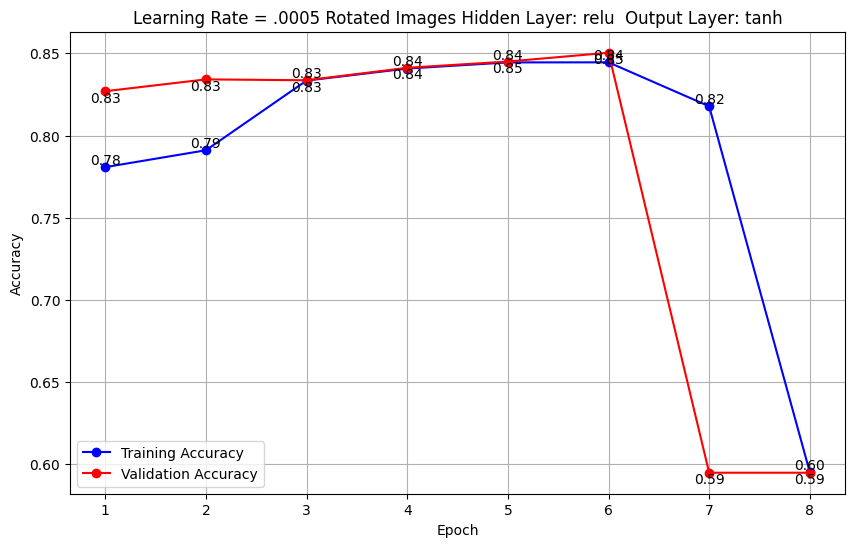

In [18]:
# Test different hidden layers

output_layers = ["softmax", "tanh"]
hidden_layer = "relu"
for output_layer in output_layers:
    dropout_value = .25
    inputs = keras.Input(shape=(32,32,3))
    convolution = inputs
    for i in range(0,1):
        convolution = convolution_block(convolution, 32, hidden_layer)
        convolution = convolution_block(convolution, 32, hidden_layer)
        convolution = pool_block(convolution)

    flatten= keras.layers.Flatten()(convolution)

    activation = flatten
    for i in range(0,1):
        activation = activation_block(activation,1024)
        activation = dropout_block(activation, dropout_value)
    outputs = keras.layers.Dense(1, activation=output_layer)(activation)
    full_model = keras.Model(inputs, outputs)
    start_time = timeit.default_timer()
    callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
    _, history = run_model(full_model, .0005, X_rotated, y_rotated, callbacks = callback)
    print(timeit.default_timer() - start_time)
    text = "Learning Rate = .0005 Rotated Images Hidden Layer: " + hidden_layer + "  Output Layer: " + output_layer
    del(full_model)
    reset_keras()

## Best Hidden and Output Layer
PReLU did not end up working with Keras for some reason.  It does not apppear to be a standard tensor flow output layer.  I will continue with RELU.  
Sigmoid was the only output layer that produced viable results.  
## Number of convolutional layers
There is a upper bound on the number of convolutional layers.  This is due to the very small size of the images.  I will test with 2 convolutional layers which is the max.


124.1541134250001


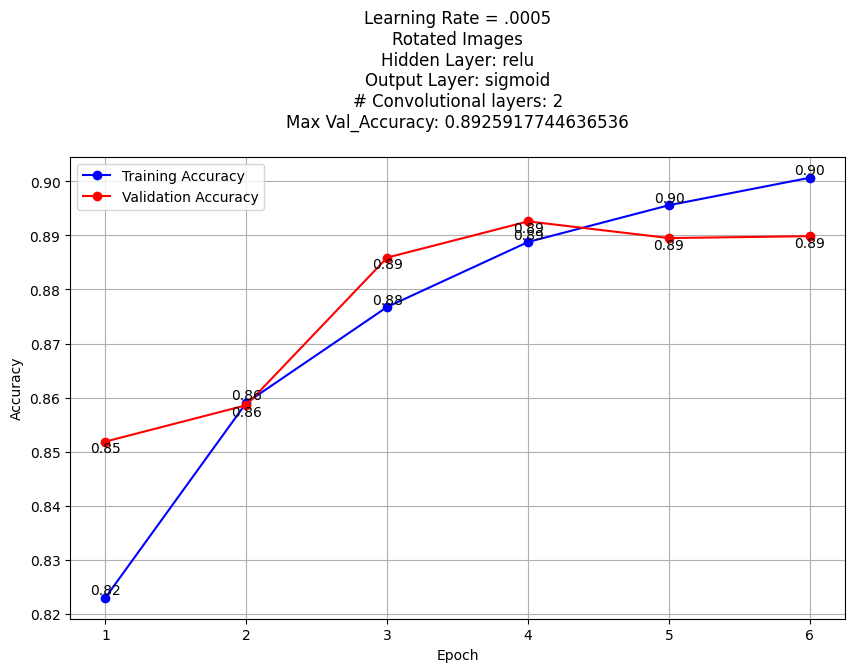

In [29]:
# Test number of convolutional layers

output_layer ="sigmoid"
hidden_layer = "relu"
hidden_layer_count = [2]
for h_layer_count in hidden_layer_count:
    dropout_value = .25
    inputs = keras.Input(shape=(32,32,3))
    convolution = inputs
    for i in range(0,h_layer_count):
        convolution = convolution_block(convolution, 32, hidden_layer)
        convolution = convolution_block(convolution, 32, hidden_layer)
        convolution = pool_block(convolution)

    flatten= keras.layers.Flatten()(convolution)

    activation = flatten
    for i in range(0,1):
        activation = activation_block(activation,1024)
        activation = dropout_block(activation, dropout_value)
    outputs = keras.layers.Dense(1, activation=output_layer)(activation)
    full_model = keras.Model(inputs, outputs)
    start_time = timeit.default_timer()
    callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
    _, history = run_model(full_model, .0005, X_rotated, y_rotated,epochs = 15, callbacks = callback)
    print(timeit.default_timer() - start_time)
    text = (
        f"Learning Rate = .0005\n"
        f"Rotated Images\n"
        f"Hidden Layer: {hidden_layer}\n"
        f"Output Layer: {output_layer}\n"
        f"# Convolutional layers: {h_layer_count}\n"
        f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
    )    
    plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    del(full_model)
    reset_keras()
    

## Results
.91 is a slight improvement. The increased model component definitly affected the outcome.  This model required additional epochs to get to find the maximum accuracy.

## Convolution Filter Tuning
I am now going to tune Convolution Filters.  


167.1898630920041


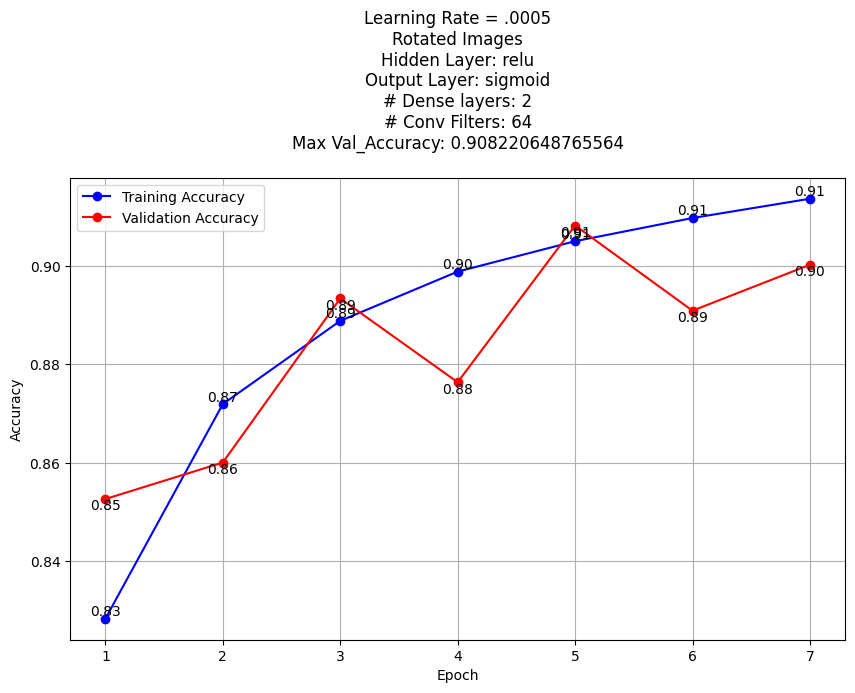

373.50291641499643


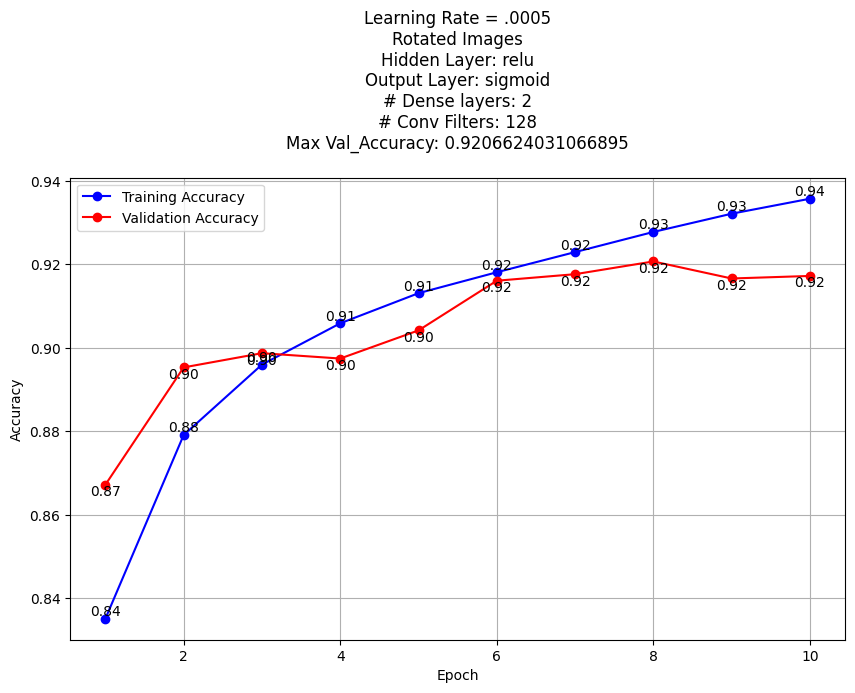

565.7961183750012


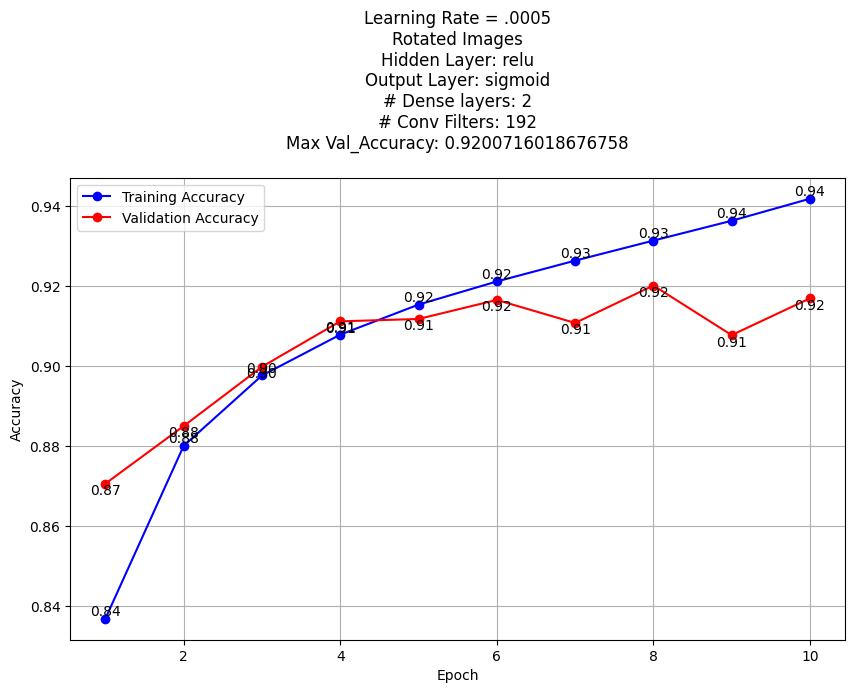

733.7660677659951


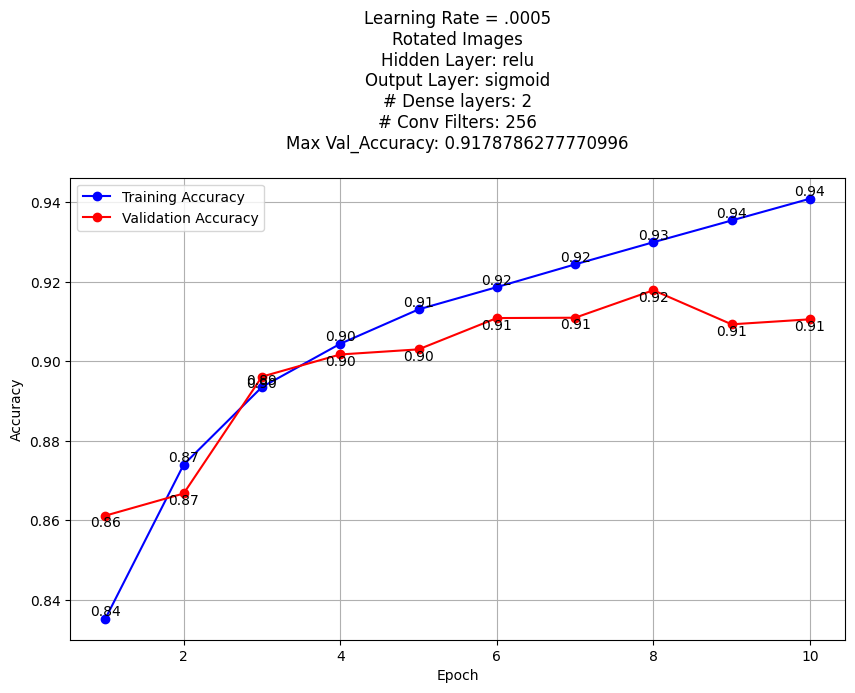

In [30]:
# Test different hidden layers

output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2
convolution_filters = [64,128,192,256]
for convolution_filter in convolution_filters:
    dropout_value = .25
    inputs = keras.Input(shape=(32,32,3))
    convolution = inputs
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution)        

    flatten= keras.layers.Flatten()(convolution)

    activation = flatten
    for i in range(0,1):
        activation = activation_block(activation,1024)w
        activation = dropout_block(activation, dropout_value)
        
    outputs = keras.layers.Dense(1, activation=output_layer)(activation)
    full_model = keras.Model(inputs, outputs)
    start_time = timeit.default_timer()
    callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
    _, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
    print(timeit.default_timer() - start_time)
    text = (
        f"Learning Rate = .0005\n"
        f"Rotated Images\n"
        f"Hidden Layer: {hidden_layer}\n"
        f"Output Layer: {output_layer}\n"
        f"# Dense layers: {h_layer_count}\n"
        f"# Conv Filters: {convolution_filter}\n"
        f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
    )    
    plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    del(full_model)
    reset_keras()

This is a supprise.  This caused a net decrease in the accuracy.  I also didn't see the high level of overfitting I expected.

## I'm going to try increasing the dropout rate and dropping the learning rate.
I'm going to try to tune the number of filters in each layer of the Conv-Conv-Pool cycle.  I'll start with 32 convolution filters.

2024-04-21 20:05:54.997072: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 20:05:55.007061: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 20:05:55.007486: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

251.3499553770016


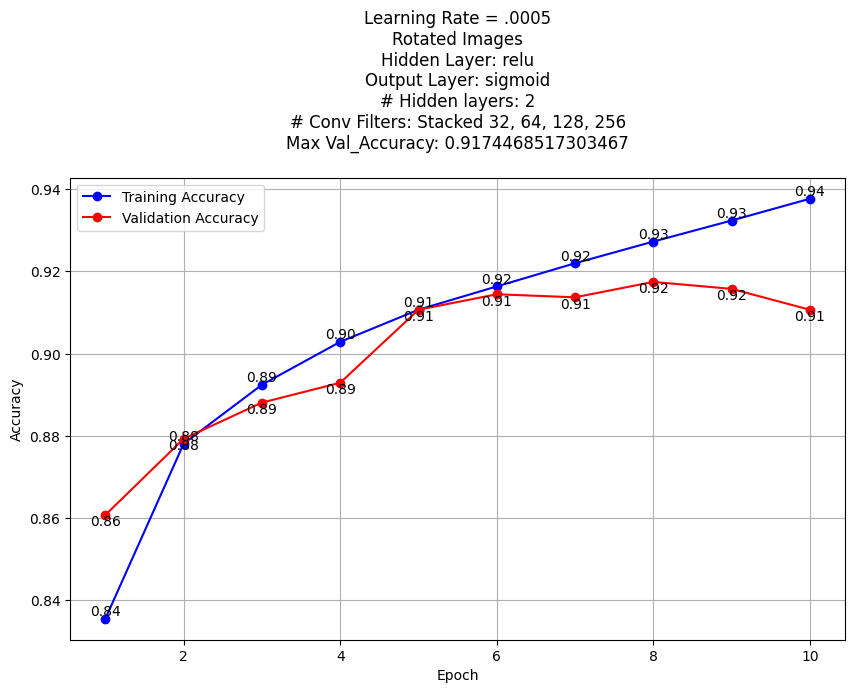

In [11]:
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2

dropout_value = .25
inputs = keras.Input(shape=(32,32,3))
convolution = inputs
convolution = convolution_block(convolution, 32, hidden_layer)
convolution = convolution_block(convolution, 64, hidden_layer)
convolution = pool_block(convolution)
convolution = convolution_block(convolution, 128, hidden_layer)
convolution = convolution_block(convolution, 256, hidden_layer)
convolution = pool_block(convolution)        

flatten= keras.layers.Flatten()(convolution)

activation = flatten
for i in range(0,1):
    activation = activation_block(activation,1024)
    activation = dropout_block(activation, dropout_value)
    
outputs = keras.layers.Dense(1, activation=output_layer)(activation)
full_model = keras.Model(inputs, outputs)
start_time = timeit.default_timer()
callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
_, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
print(timeit.default_timer() - start_time)
text = (
    f"Learning Rate = .0005\n"
    f"Rotated Images\n"
    f"Hidden Layer: {hidden_layer}\n"
    f"Output Layer: {output_layer}\n"
    f"# Hidden layers: {h_layer_count}\n"
    f"# Conv Filters: Stacked 32, 64, 128, 256\n"
    f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
)    
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(full_model)
reset_keras()

482.19846897900425


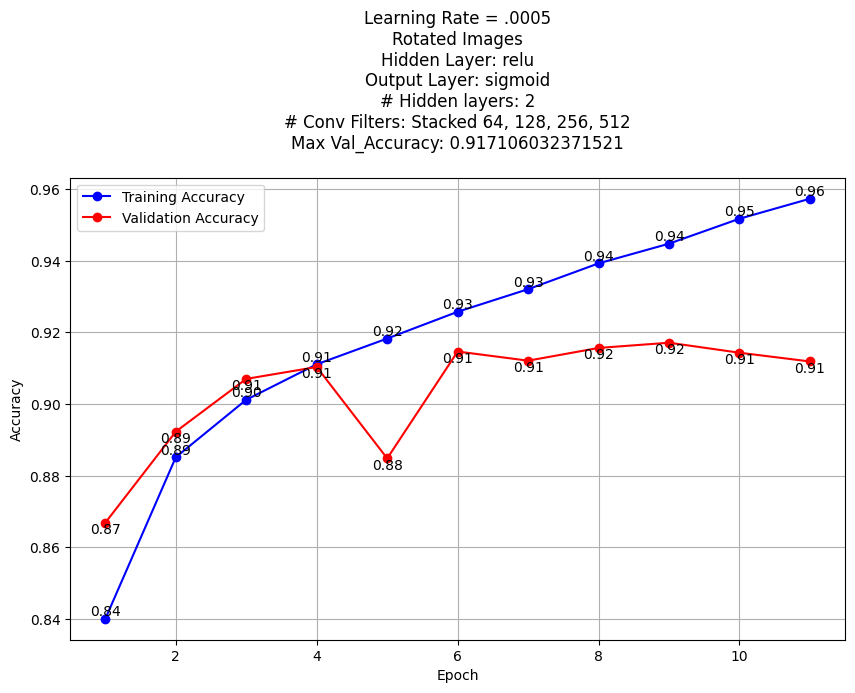

In [12]:
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2

dropout_value = .25
inputs = keras.Input(shape=(32,32,3))
convolution = inputs
convolution = convolution_block(convolution, 64, hidden_layer)
convolution = convolution_block(convolution, 128, hidden_layer)
convolution = pool_block(convolution)
convolution = convolution_block(convolution, 256, hidden_layer)
convolution = convolution_block(convolution, 512, hidden_layer)
convolution = pool_block(convolution)        

flatten= keras.layers.Flatten()(convolution)

activation = flatten
for i in range(0,1):
    activation = activation_block(activation,1024)
    activation = dropout_block(activation, dropout_value)
    
outputs = keras.layers.Dense(1, activation=output_layer)(activation)
full_model = keras.Model(inputs, outputs)
start_time = timeit.default_timer()
callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
_, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
print(timeit.default_timer() - start_time)
text = (
    f"Learning Rate = .0005\n"
    f"Rotated Images\n"
    f"Hidden Layer: {hidden_layer}\n"
    f"Output Layer: {output_layer}\n"
    f"# Hidden layers: {h_layer_count}\n"
    f"# Conv Filters: Stacked 64, 128, 256, 512\n"
    f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
)    
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(full_model)
reset_keras()

1117.442447827998


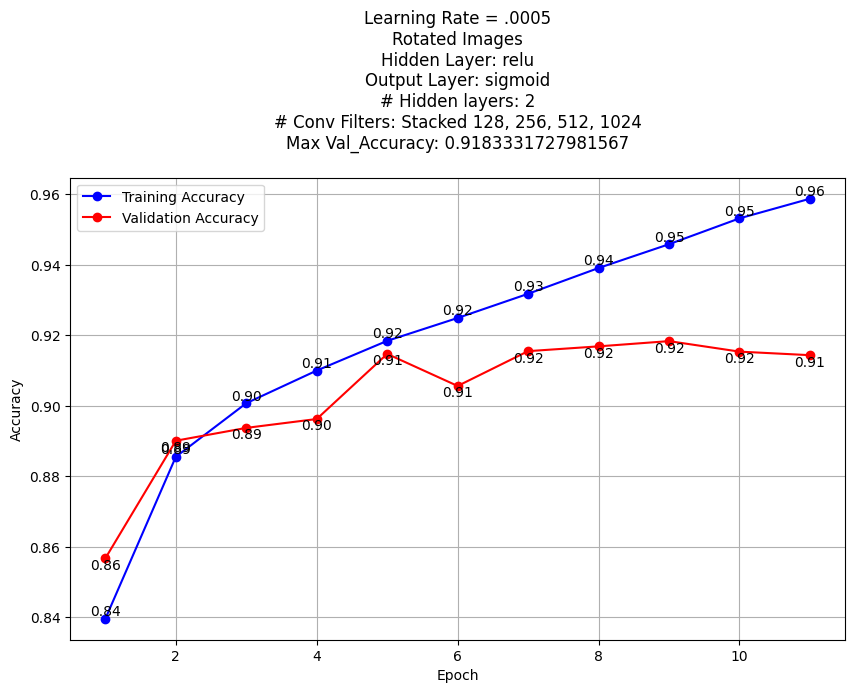

In [19]:
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2

dropout_value = .25
inputs = keras.Input(shape=(32,32,3))
convolution = inputs
convolution = convolution_block(convolution, 128, hidden_layer)
convolution = convolution_block(convolution, 256, hidden_layer)
convolution = pool_block(convolution)
convolution = convolution_block(convolution, 512, hidden_layer)
convolution = convolution_block(convolution, 1024, hidden_layer)
convolution = pool_block(convolution)        

flatten= keras.layers.Flatten()(convolution)

activation = flatten
for i in range(0,1):
    activation = activation_block(activation,1024)
    activation = dropout_block(activation, dropout_value)
    
outputs = keras.layers.Dense(1, activation=output_layer)(activation)
full_model = keras.Model(inputs, outputs)
start_time = timeit.default_timer()
callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
_, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
print(timeit.default_timer() - start_time)
text = (
    f"Learning Rate = .0005\n"
    f"Rotated Images\n"
    f"Hidden Layer: {hidden_layer}\n"
    f"Output Layer: {output_layer}\n"
    f"# Hidden layers: {h_layer_count}\n"
    f"# Conv Filters: Stacked 128, 256, 512, 1024\n"
    f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
)    
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(full_model)
reset_keras()

## Results of convolutional testing
Convolutional testing showed that more filters improved the performance to a point.  I also found via research that it is normal to increase the number of filters as layers progress.  I like the performance curve of 64, 128, 256, 512 and will use that going forward.

## Tuning dense layers
There are 3 hyperparamaters to tune in dense layers.  The first is the number of dense layers, the size of dense layers, and the dropout factor between dense layers.  I will be trying 1, 2, and 3 dense layers with differing sizes.

## Updating the plot
I want to clean up my plotting.  To do this, I had ChatGPT make me anew plotting function.

2024-04-22 17:36:04.007364: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 17:36:04.014481: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 17:36:04.014798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Execution Time: 246.68268815799092


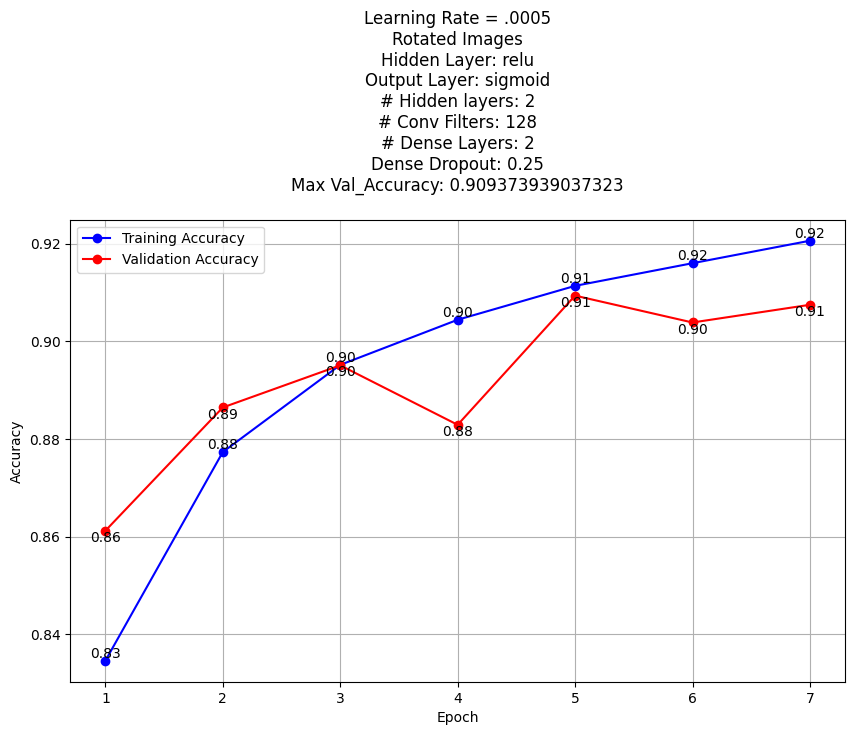

Execution Time: 180.99191621800128


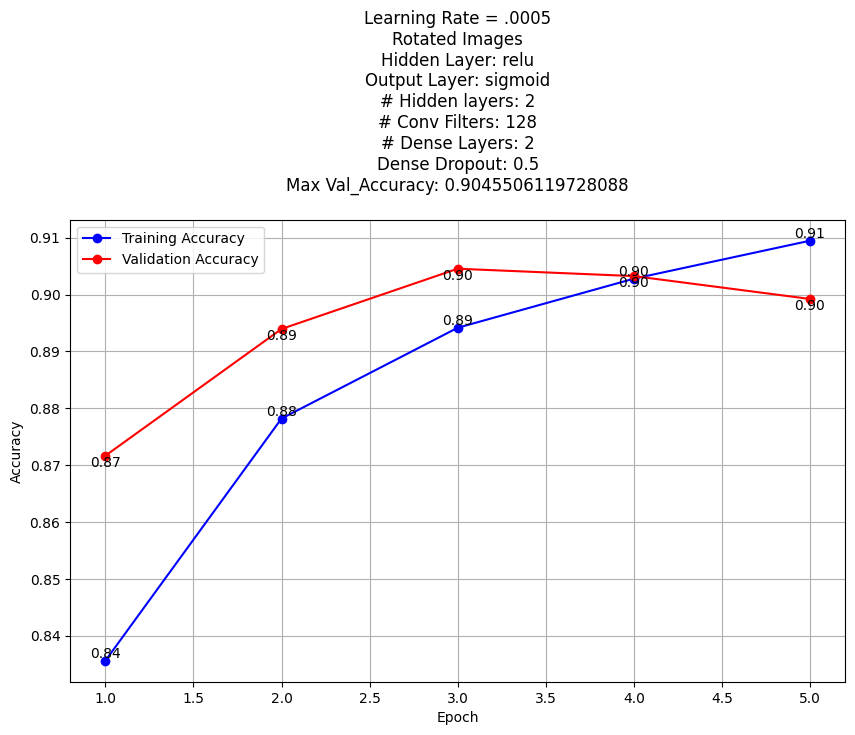

Execution Time: 279.95629033099976


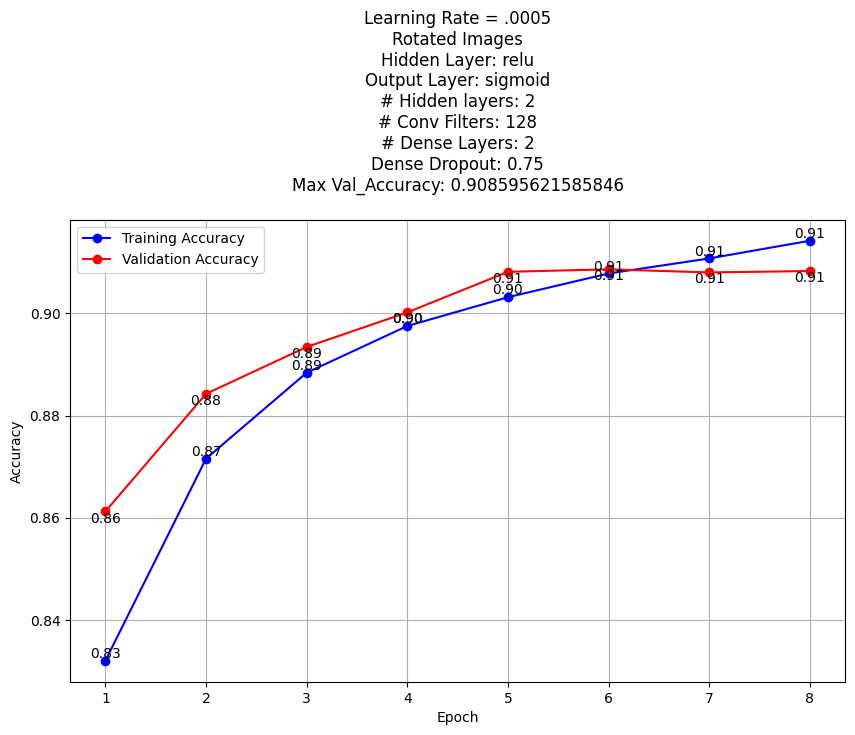

In [13]:

output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2
dense_layers  = 2
dense_dropout_layers = [.25, .5, .75]
convolution_filter = 128

for dropout_value in dense_dropout_layers:
    inputs = keras.Input(shape=(32,32,3))
    convolution = inputs
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution)         
    
    flatten= keras.layers.Flatten()(convolution)
    
    activation = flatten
    for i in range(0,dense_layers):
        activation = activation_block(activation,1024)
        activation = dropout_block(activation, dropout_value)
        
    outputs = keras.layers.Dense(1, activation=output_layer)(activation)
    full_model = keras.Model(inputs, outputs)
    
    text = (
        f"Learning Rate = .0005\n"
        f"Rotated Images\n"
        f"Hidden Layer: {hidden_layer}\n"
        f"Output Layer: {output_layer}\n"
        f"# Hidden layers: {h_layer_count}\n"
        f"# Conv Filters: {convolution_filter}\n"
        f"# Dense Layers: {dense_layers}\n"
        f'Dense Dropout: {dropout_value}\n'
    )
    
    start_time = timeit.default_timer()
    callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
    _, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
    print("Execution Time: " + str(timeit.default_timer() - start_time))
    text = text + f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
    plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    #plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    del(full_model)
    reset_keras()

I0000 00:00:1713808126.252727    4959 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1713808126.778481    4954 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 652 bytes spill stores, 824 bytes spill loads

I0000 00:00:1713808130.770635    5043 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 260 bytes spill stores, 260 bytes spill loads



Execution Time: 406.4527018860099


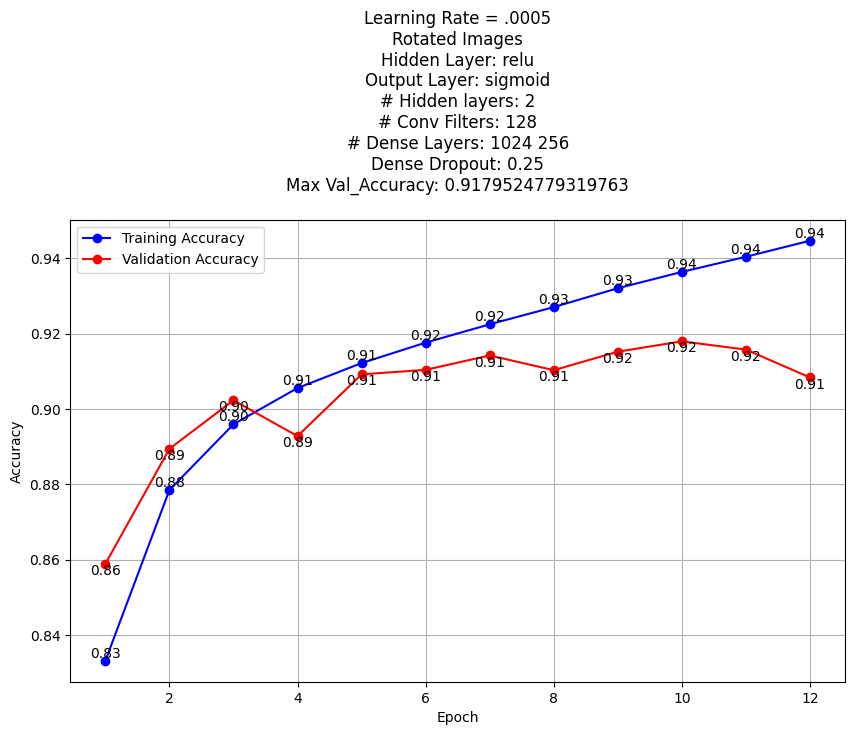

In [14]:
train_results = []
val_results = []
train_labels = []
val_labels = []
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2
dense_layers  = 2
dropout_value = .25


inputs = keras.Input(shape=(32,32,3))
convolution = inputs
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = pool_block(convolution)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = pool_block(convolution)        

flatten= keras.layers.Flatten()(convolution)

activation = flatten

activation = activation_block(activation,1024)
activation = dropout_block(activation, dropout_value)
activation = activation_block(activation,256)
activation = dropout_block(activation, dropout_value)
    
outputs = keras.layers.Dense(1, activation=output_layer)(activation)
full_model = keras.Model(inputs, outputs)

text = (
    f"Learning Rate = .0005\n"
    f"Rotated Images\n"
    f"Hidden Layer: {hidden_layer}\n"
    f"Output Layer: {output_layer}\n"
    f"# Hidden layers: {h_layer_count}\n"
    f"# Conv Filters: {convolution_filter}\n"
    f"# Dense Layers: 1024 256\n"
    f'Dense Dropout: {dropout_value}\n'
)

start_time = timeit.default_timer()
callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
_, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
print("Execution Time: " + str(timeit.default_timer() - start_time))
text = text + f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
#plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(full_model)
reset_keras()

Execution Time: 385.29955521998636


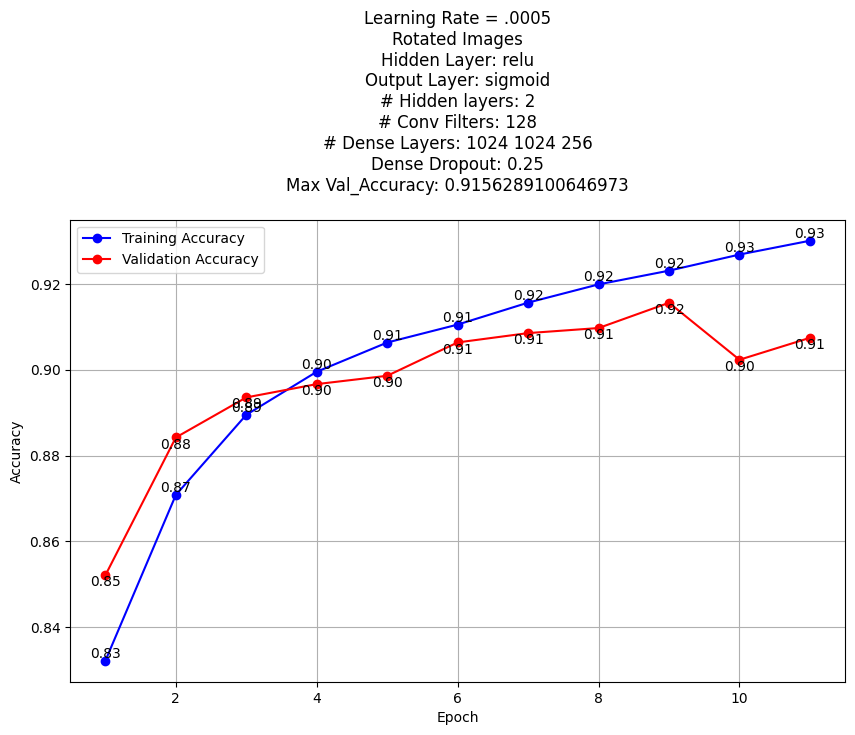

In [15]:
## train_results = []
val_results = []
train_labels = []
val_labels = []
output_layer ="sigmoid"
hidden_layer = "relu"
h_layer_count = 2
dense_layers  = 2
dropout_value = .25


inputs = keras.Input(shape=(32,32,3))
convolution = inputs
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = pool_block(convolution)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = convolution_block(convolution, convolution_filter, hidden_layer)
convolution = pool_block(convolution) 

flatten= keras.layers.Flatten()(convolution)

activation = flatten

activation = activation_block(activation,1024)
activation = dropout_block(activation, dropout_value)
activation = activation_block(activation,1024)
activation = dropout_block(activation, dropout_value)
activation = activation_block(activation,256)
activation = dropout_block(activation, dropout_value)
    
outputs = keras.layers.Dense(1, activation=output_layer)(activation)
full_model = keras.Model(inputs, outputs)

text = (
    f"Learning Rate = .0005\n"
    f"Rotated Images\n"
    f"Hidden Layer: {hidden_layer}\n"
    f"Output Layer: {output_layer}\n"
    f"# Hidden layers: {h_layer_count}\n"
    f"# Conv Filters: {convolution_filter}\n"
    f"# Dense Layers: 1024 1024 256\n"
    f'Dense Dropout: {dropout_value}\n'
)

start_time = timeit.default_timer()
callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
_, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
print("Execution Time: " + str(timeit.default_timer() - start_time))
text = text + f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
#plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
del(full_model)
reset_keras()


## Unexpected Results for the dense layers

Execution Time: 242.7694233779912


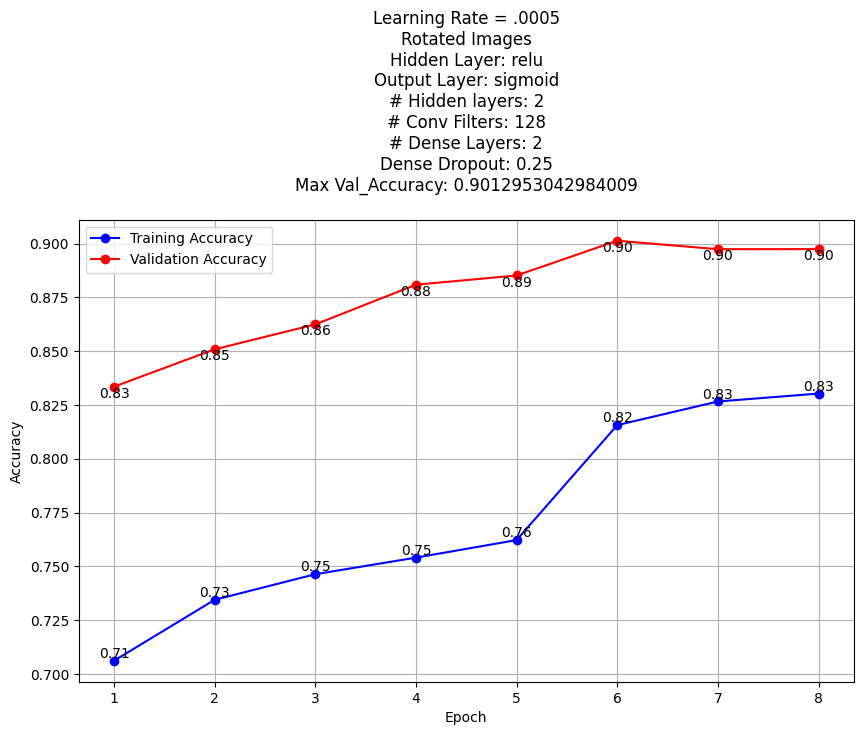

Execution Time: 292.7981484729971


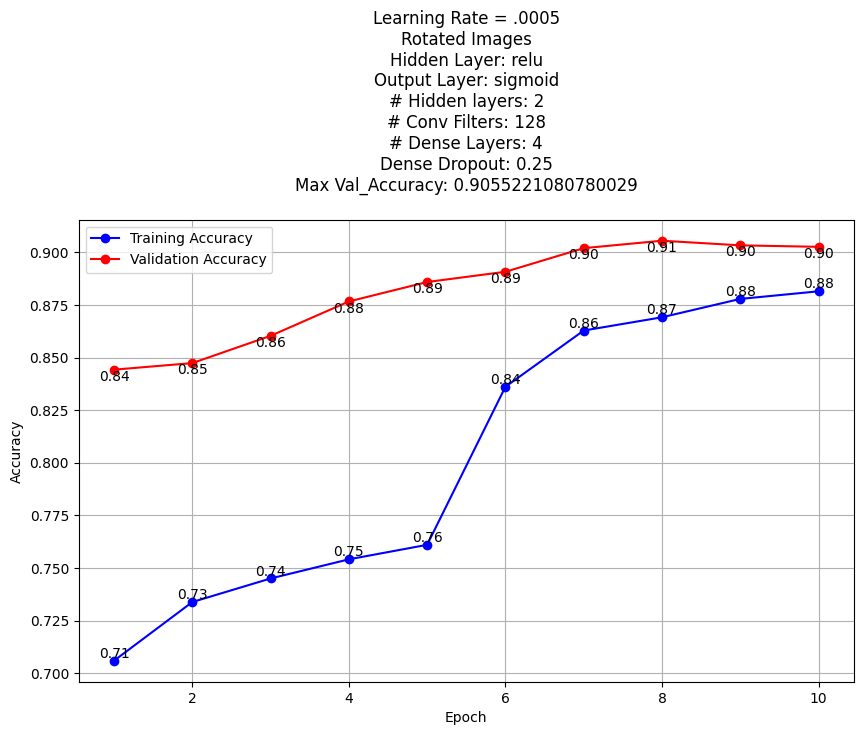

Execution Time: 319.487963594991


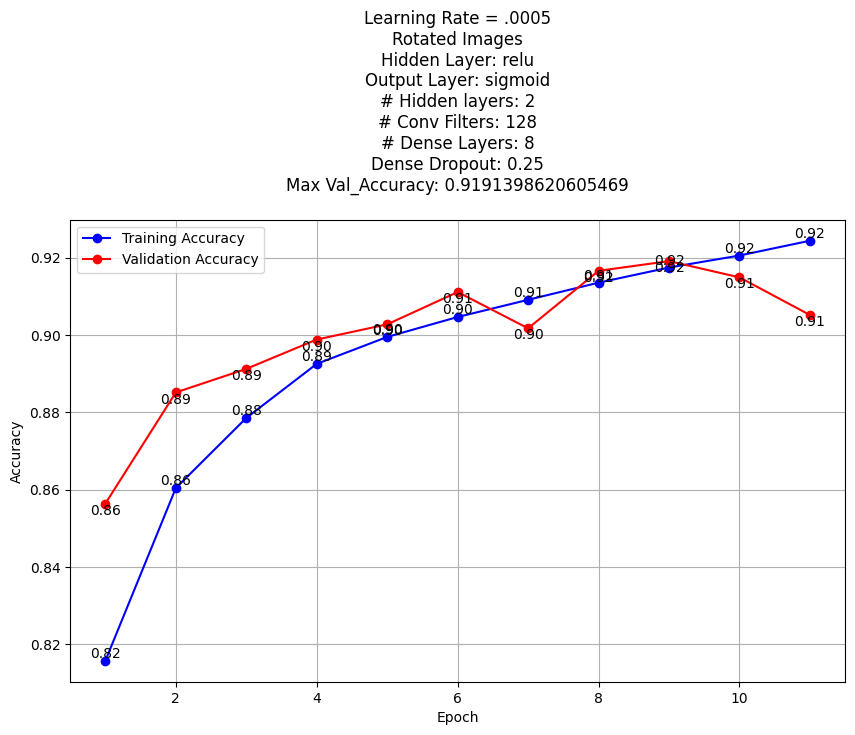

Execution Time: 320.9090027989878


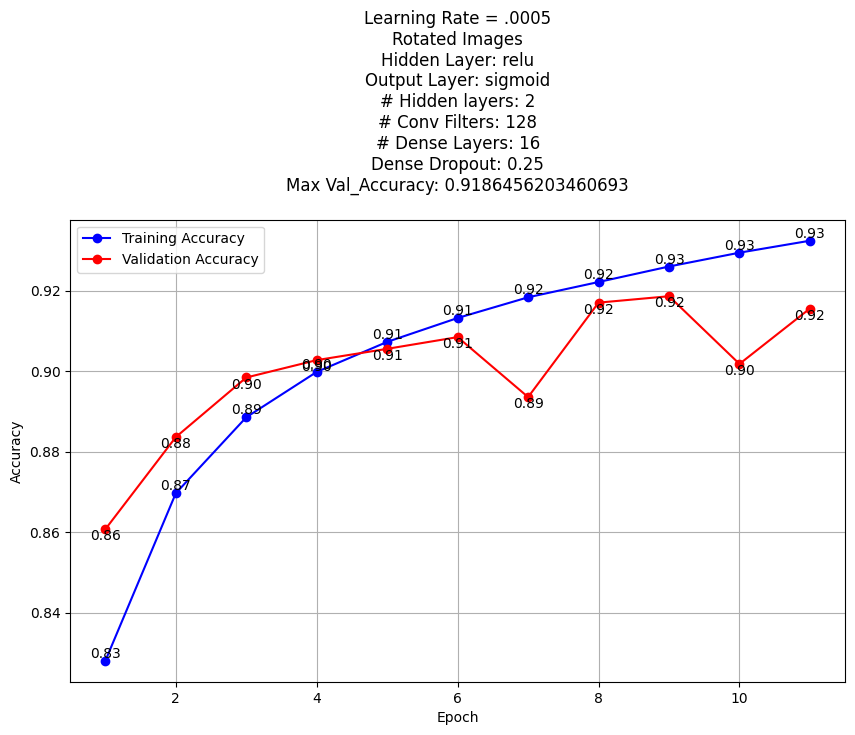

Execution Time: 265.06038975997944


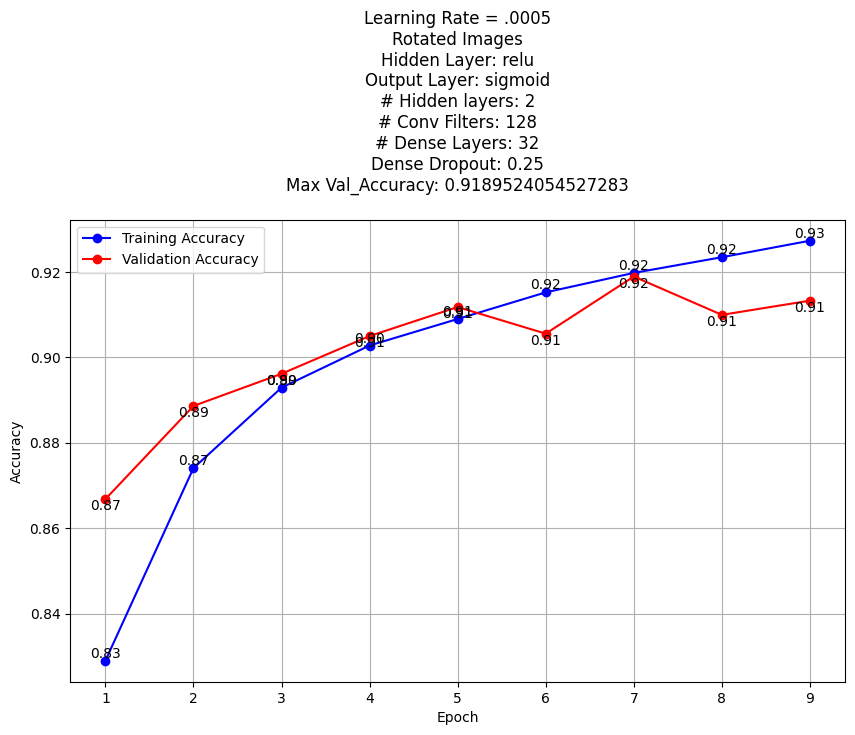

Execution Time: 264.8384584519954


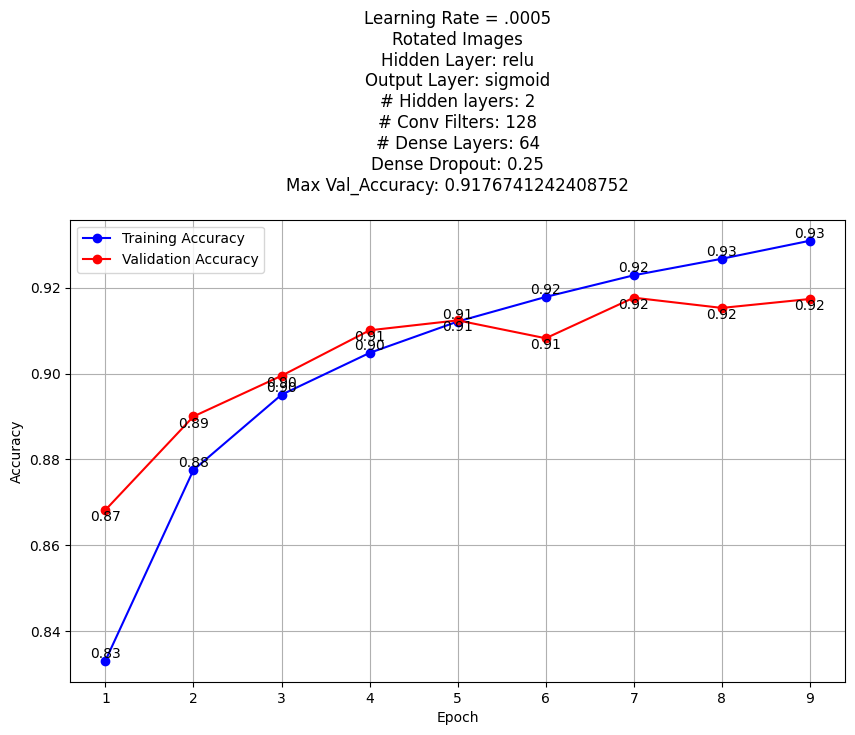

Execution Time: 213.53608591400553


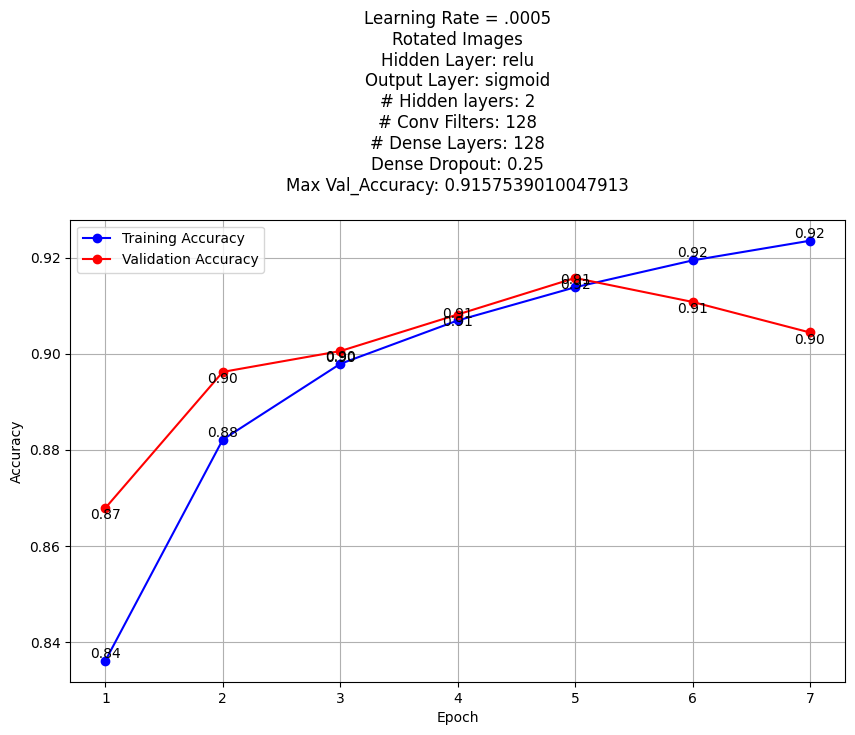

Execution Time: 242.05188294898835


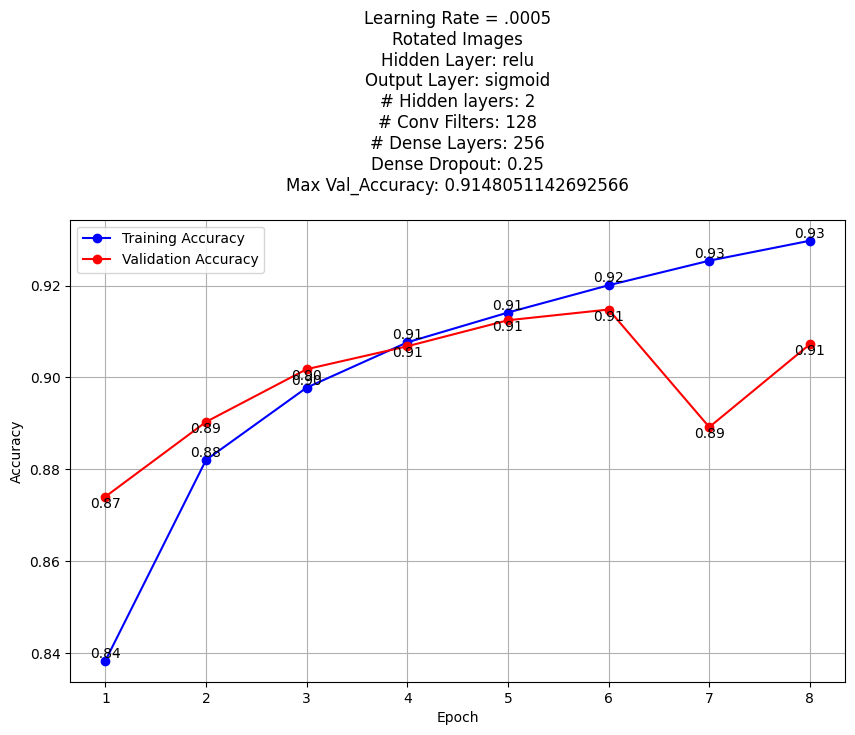

Execution Time: 301.298121394997


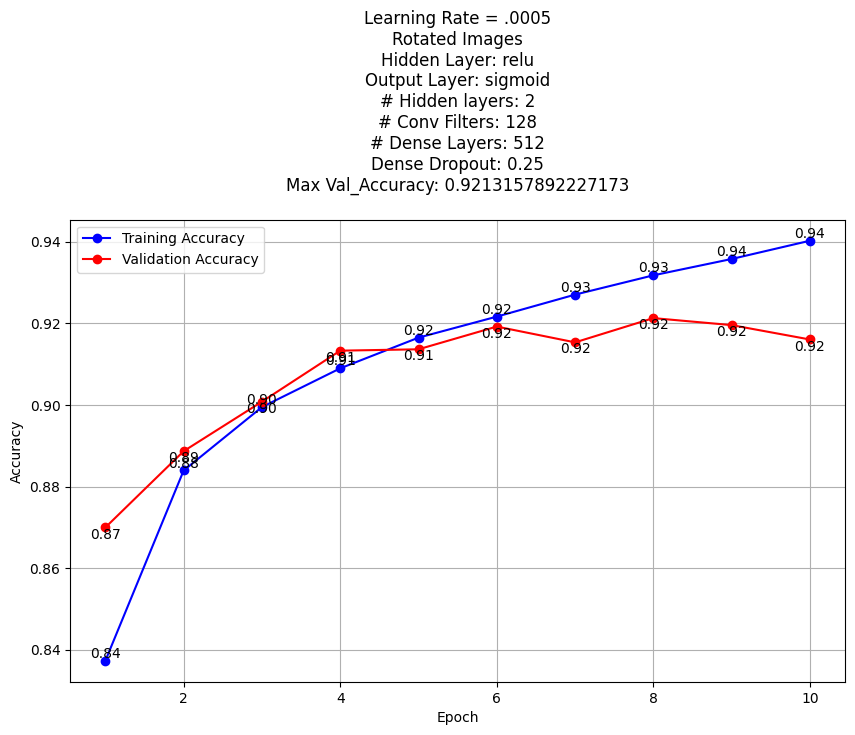

Execution Time: 261.80531732400414


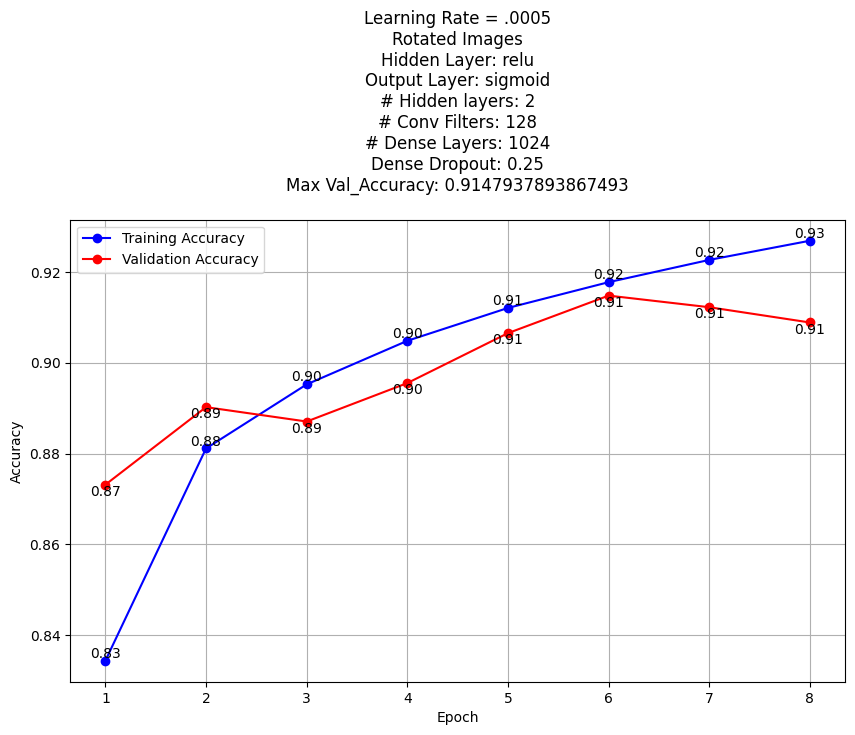

In [18]:
output_layer ="sigmoid"
hidden_layer = "relu"
convolution_filter = 128
h_layer_count = 2
dense_layers  = 1
dropout_value = .25
dense_layer_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


for dense_layer_size in dense_layer_sizes:
    inputs = keras.Input(shape=(32,32,3))
    convolution = inputs
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = convolution_block(convolution, convolution_filter, hidden_layer)
    convolution = pool_block(convolution)        
    
    flatten= keras.layers.Flatten()(convolution)
    
    activation = flatten
    
    activation = activation_block(activation,dense_layer_size)
    activation = dropout_block(activation, dropout_value)
        
    outputs = keras.layers.Dense(1, activation=output_layer)(activation)
    full_model = keras.Model(inputs, outputs)
    
    text = (
        f"Learning Rate = .0005\n"
        f"Rotated Images\n"
        f"Hidden Layer: {hidden_layer}\n"
        f"Output Layer: {output_layer}\n"
        f"# Hidden layers: {h_layer_count}\n"
        f"# Conv Filters: {convolution_filter}\n"
        f"# Dense Layers: {dense_layer_size}\n"
        f'Dense Dropout: {dropout_value}\n'
    )
    
    start_time = timeit.default_timer()
    callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=2)
    _, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 15, callbacks = callback)
    print("Execution Time: " + str(timeit.default_timer() - start_time))
    text = text + f'Max Val_Accuracy: {max(history.history["val_binary_accuracy"])}\n'
    plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    #plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    del(full_model)
    reset_keras()